# Liability Hedging Portfolios

Liability hedging portfolios are extremely meaningful and important building blocks in the design of investment solutions.

### Investor's Main Concern

Institutional investors' main concern is an unexpected icnrease in the present value of their liabilites relative to the value of their assets.

### Hedging = Cash-Flow Matching

Liability-Hedging Portfolios (LHP) or Goal-Hedging Portfolios (GHP) are portfolios with payoffs matching the date and nominal amount of liability/goal payments.

### Standard Bonds vs Retirement Bonds

If for example an individual investor wanted to retire in the year 2039 and will need replacement income cashflows for 20 years from 2035 and onwards. In this context, a standard bond with maturity dates say 2044 is not going to be safe with respect to the retirement goal. The standard bond is going to start paying coupon payments on some sort of time basis until a maturity date, then they will pay a big payment. However, this individual investor does not need payments when they are not retired, they only need money when they are going to retire. The kind of bond/cash-flow payoffs that the investor would need would be paid by a GHP would be defined as a retirement bond. A retirement bond is one that will pay a series of constant cash-flows starting at retirment date and not immediately. 

Retirement bonds or retirement bond portfolios are highly volatile because they are so long term so when the interest rate varies the value of this bond portfolio changes a lot. However, if we look at the return on the funding ratio instead of just return from assets we can see that the retirement bond holds zero risk by assumption, this is because the retirement bond perfectly replicats the liabilites which in this case are defined as replacement income payments for 20 years of retirement.

### From Cash-Flow Matching to Factor Exposure Matching

In implementation, when and if feasible, we can buy pure discount bonds with maturity dates and nominal amounts matching our liabilities. in practice this is not very convenient as we don't have access to all these specific bonds with all the needed maturities. So, in this case, where cash-flow matching is not feasible, one may use factor exposure matching instead. 

First we are going to immunise the asset portfolio with respect to changes in interest rate. We do this by simply holding a bond portfolio that has the exact same duration as the liability portfolio. If that's the case and there is a small decerease in interest rat, liability value withh of course go up but the bond portfolio on the asset side is going to go up by about the same because they have, by construction, the same duration. 

# Lab Session - CIR Model to Simulate Changes in Interest Rates and Liability Hedging 

The Cox Ingersoll Ross model is used to model the dynamics of interest rates and is an extension of the popular Vasicek model to prevent negative interest rates:

$$ \mathop{\mathrm{d}r_t} = a\left(b-r_t\right)\mathop{\mathrm{d}t} + \hspace{2pt}\sigma \sqrt{r_t} \mathop{\mathrm{d}W_{t}} .$$

### Short Rate vs Annual

In [4]:
# interest rate of 100% on 1 dollar applied different amounts of times
print(1 + 1*1)
print(1 + 1*0.5 + (1 + 1*0.5)*0.5)
print(1 + 1*0.25 + (1 + 1*0.25)*0.25 + (1 + 1*0.25 + (1 + 1*0.25)*0.25)*0.25 + (1 + 1*0.25 + (1 + 1*0.25)*0.25 + (1 + 1*0.25 + (1 + 1*0.25)*0.25)*0.25)*0.25)

2
2.25
2.44140625


In general, if we compound every 1/N of a year (N times a year) we get:

$$\left(1+\frac{r}{N}\right)^N$$

In [7]:
print((1+1/1)**1)
print((1+1/2)**2)
print((1+1/4)**4)
print((1+1/10000)**10000)

2.0
2.25
2.44140625
2.7181459268249255


As N becomes very large we get the generalisation:

$$1 + r_{annual} = e^{r_{inst}}$$

$$r_{annual} = e^{r_{inst}} - 1$$

$$r_{inst} = \ln(1+r_{annual})$$

In [8]:
import pandas as pd
import numpy as np
import edhec_risk_kit as erk
import ipywidgets as widgets

%load_ext autoreload
%autoreload 2

In [13]:
def inst_to_ann(r):
    ''' 
    Converts short rate to an annualised rate 
    '''
    return np.expm1(r)

def ann_to_inst(r):
    ''' 
    Convert annual rate to a short rate 
    '''
    return np.log1p(r)

In [14]:
def cir(n_years = 10, n_scenarios = 1, a = 0.05, b = 0.03, sigma = 0.05, steps_per_year = 12, r_0 = None):
    ''' 
    Implements the CIR model for interest ratees
    '''
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year

    num_steps = int(n_years * steps_per_year) + 1
    shock = np.random.normal(0, scale = np.sqrt(dt), size = (num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0

    for step in range(1, num_steps):
        r_t = rates[step - 1]
        dr_t = a*(b - r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + dr_t)

    return pd.DataFrame(data = inst_to_ann(rates), index = range(num_steps))

<AxesSubplot:>

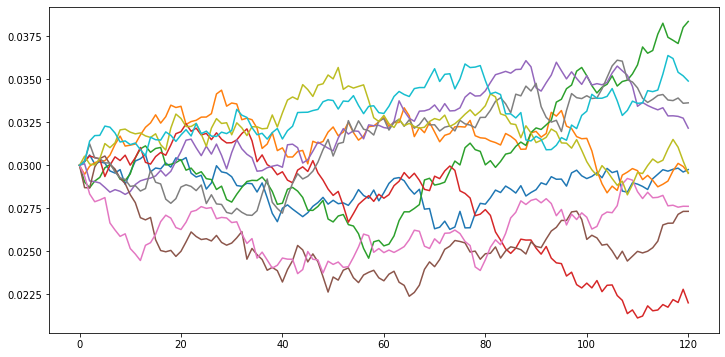

In [17]:
cir(n_scenarios = 10, sigma = 0.01).plot(figsize = (12, 6), legend = False)

In [18]:
def show_cir(r_0 = 0.03, a = 0.5, b = 0.03, sigma = 0.05, n_scenarios = 5):
    cir(r_0 = r_0, a = a, b = b, sigma = sigma, n_scenarios = n_scenarios).plot(legend = False, figsize = (12, 5))

In [19]:
controls = widgets.interactive(show_cir,
                                r_0 = (0, 0.15, 0.01),
                                a = (0, 1, 0.1),
                                b = (0, 0.15, 0.01),
                                sigma = (0, 0.1, 0.01),
                                n_scenarios = (1, 100))

In [20]:
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

The model can also be used to generate the movement of bond prices for a zero coupon bond that are implied by the generated interest rate, using the following equations:

$$P(t, T) = A(t, T)e^{-B(t, T)r_t},$$

where 

$$A(t, T) = \left(\frac{2he^{(a+h)\tau/2}}{2h+(a+h)(e^{\tau h}-1)}\right)^{2ab/\sigma^2},$$

$$ B(t,T) = \frac{2(e^{\tau h}-1)}{2h+(a+h)(e^{\tau h}-1)},$$

$$h = \sqrt{a^2 + 2\sigma^2},$$

$$ \tau = T - t .$$

In [21]:
def cir(n_years = 10, n_scenarios = 1, a = 0.05, b = 0.03, sigma = 0.05, steps_per_year = 12, r_0 = None):
    ''' 
    Generate random interest rate eveolution over time using the CIR model
    b and r_0 are assured to be the annualised rates, not the short rate
    and the returned values are the annualised rates as well
    '''
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year

    num_steps = int(n_years * steps_per_year) + 1
    shock = np.random.normal(0, scale = np.sqrt(dt), size = (num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0

    # for price generation
    h = np.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)

    def price(ttm, r):
        _A = ((2*h*np.exp((h+a)*ttm/2))/(2*h+(h+a)*(np.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(np.exp(h*ttm)-1))/(2*h + (h+a)*(np.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    prices[0] = price(n_years, r_0)
    
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        # generate prices at time t as well ...
        prices[step] = price(n_years-step*dt, rates[step])

    rates = pd.DataFrame(data = inst_to_ann(rates), index=range(num_steps))
    # for prices
    prices = pd.DataFrame(data = prices, index = range(num_steps))
    return rates, prices

In [25]:
def show_cir_prices(r_0 = 0.03, a = 0.5, b = 0.03, sigma = 0.05, n_scenarios = 5):
    cir(r_0 = r_0, a = a, b = b, sigma = sigma, n_scenarios = n_scenarios)[1].plot(legend = False, figsize = (12, 5))

In [26]:
controls = widgets.interactive(show_cir_prices,
                                r_0 = (0, 0.15, 0.01),
                                a = (0, 1, 0.1),
                                b = (0, 0.15, 0.01),
                                sigma = (0, 0.1, 0.01),
                                n_scenarios = (1, 100))

In [27]:
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

In [30]:
a_0 = 0.75
rates, bond_prices = cir(n_years = 10, r_0 = 0.03, b = 0.03, n_scenarios = 10)
liabilities = bond_prices
zcbond_10 = pd.Series(data = [1], index = [10])
zc_0 = erk.pv(zcbond_10, r = 0.03)
n_bonds = a_0/zc_0
av_zc_bonds = n_bonds * bond_prices
av_cash = a_0 * (1 + rates/12).cumprod()

<AxesSubplot:>

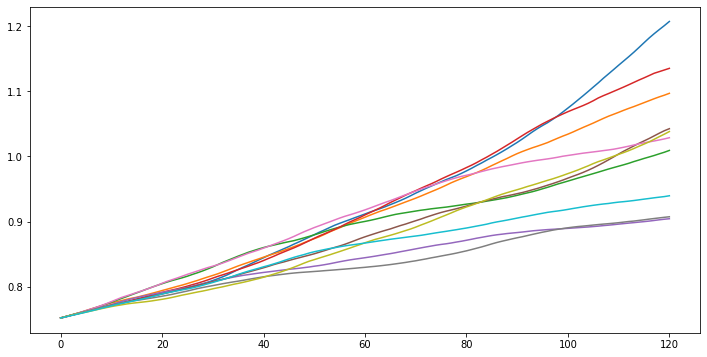

In [31]:
av_cash.plot(legend = False, figsize = (12, 6))

<AxesSubplot:>

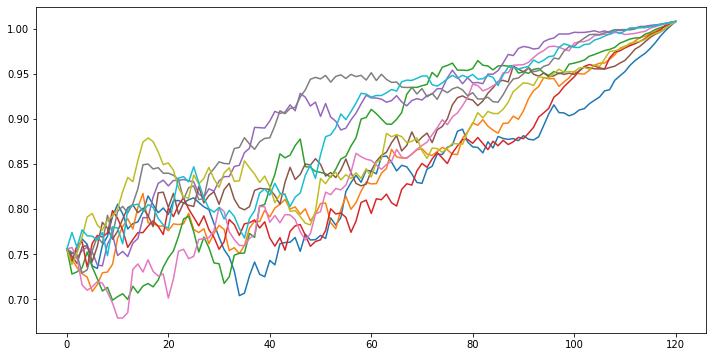

In [32]:
av_zc_bonds.plot(legend = False, figsize = (12, 6))

<AxesSubplot:title={'center':'Returns of Funding Ratio with Cash (10 scenarios)'}>

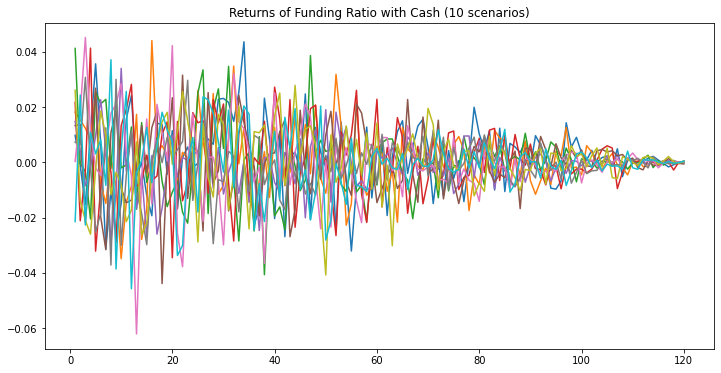

In [33]:
(av_cash/liabilities).pct_change().plot(title = 'Returns of Funding Ratio with Cash (10 scenarios)', legend = False, figsize=(12, 6))

<AxesSubplot:title={'center':'Returns of Funding Ratio with Zero Coupon Bonds (10 scenarios)'}>

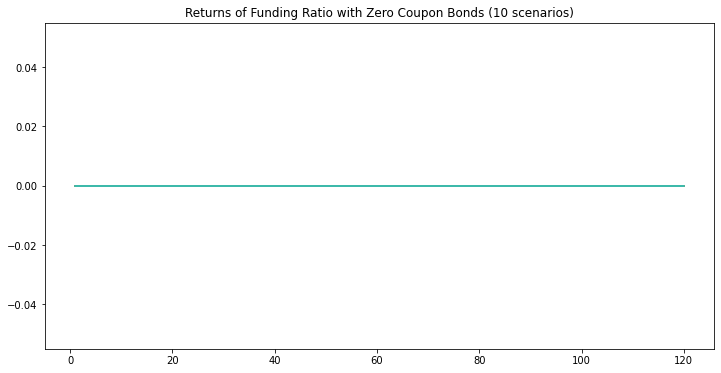

In [35]:
(av_zc_bonds/liabilities).pct_change().plot(title = 'Returns of Funding Ratio with Zero Coupon Bonds (10 scenarios)', legend = False, figsize=(12, 6))

In [46]:
a_0 = 0.75
rates, bond_prices = cir(n_scenarios = 10000, r_0 = 0.03, b = 0.03)
liabilities = bond_prices
zc_0 = erk.pv(zcbond_10, r = 0.03)
n_bonds = a_0/zc_0
av_zc_bonds = n_bonds * bond_prices
av_cash = a_0 * (1+rates/12).cumprod()

In [47]:
tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]
tfr_zc_bonds = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]

<AxesSubplot:>

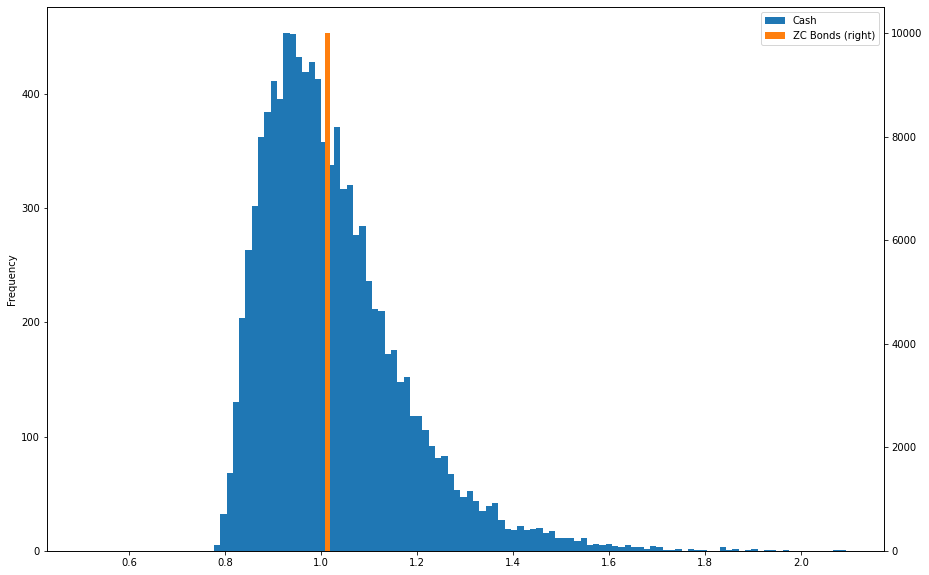

In [48]:
ax = tfr_cash.plot.hist(label = 'Cash', figsize = (15, 10), bins = 100, legend = True)
tfr_zc_bonds.plot.hist(ax = ax, label = ('ZC Bonds'), bins = 100, legend =  True, secondary_y = True)